In [ ]:
from datetime import date, datetime as dt, timedelta as td
import pytz
import time
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, SimpleRNN, GRU
import warnings
warnings.filterwarnings("ignore")

from keras.layers import Flatten, Dropout, TimeDistributed, ConvLSTM2D, Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.utils import to_categorical
import keras
import tensorflow as tf

from IPython import display
display.Javascript("google.colab.output.setIframeHeight('300px');")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Preprocessing functions

In [ ]:
PATH = 'drive/MyDrive/Colab Notebooks/StepCount.csv'
data = pd.read_csv(PATH)

In [ ]:
def convert_steps(steps, grouping=['date']):
  convert_tz = lambda x: x.to_pydatetime().replace(tzinfo=pytz.utc).astimezone(pytz.timezone('Europe/Vilnius'))
  get_year = lambda x: convert_tz(x).year
  get_month = lambda x: '{}-{:02}'.format(convert_tz(x).year, convert_tz(x).month) #inefficient
  get_date = lambda x: '{}-{:02}-{:02}'.format(convert_tz(x).year, convert_tz(x).month, convert_tz(x).day) #inefficient
  get_day = lambda x: convert_tz(x).day
  get_hour = lambda x: convert_tz(x).hour
  get_minute = lambda x: convert_tz(x).minute
  get_day_of_week = lambda x: convert_tz(x).weekday()


  steps['startDate'] = pd.to_datetime(steps['startDate'])
  steps['year'] = steps['startDate'].map(get_year)
  steps['month'] = steps['startDate'].map(get_month)
  steps['date'] = steps['startDate'].map(get_date)
  steps['day'] = steps['startDate'].map(get_day)
  steps['hour'] = steps['startDate'].map(get_hour)
  steps['dow'] = steps['startDate'].map(get_day_of_week)

  corona_start = steps[steps.date == "2020-03-10"].index[0]
  steps = steps.iloc[:corona_start, :]

  return steps.groupby(grouping)['value'].sum().reset_index(name='Steps')


#TODO: rename to "to_supervised"
def prepare_sequence(sequence, n_previous, n_future):
    """
    Input: 
        - sequence: numpy array, pandas DataFrame or list; input sequence
        - n_previous: int; number of past data points (N)
        - n_future: int; number of data points to be predicted (K)
    Returns:
        - X: (seq. length x n_previous) numpy array with the previous observations
        - y: (seq. length x n_fututre) numpy array with the target observations
    """
    
    X, y = [], []
    idx, i = 0, 0
    while idx+n_future <= len(sequence)-1:
        idx = i + n_previous
        X.append(sequence[i:idx])
        y.append(sequence[idx:idx+n_future])
        i += 1
        
    return np.array(X), np.array(y)


def season(month):
    if month in [12, 1, 2]:
        return 0
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3


def augment(steps):
    augmented = steps.groupby(['date'])['value'].sum().reset_index(name='Steps')
    dow = steps.groupby(['date']).mean()['dow']
    augmented['dow'] = (dow.apply(int)).to_list()
    month = augmented.date.apply(lambda a: int(a.split('-')[1]))
    augmented['month'] = month - 1
    augmented['season'] = month.apply(season)
    
    return augmented

# Load and prepare the data

In [ ]:
steps_by_date = convert_steps(data)
steps_by_date_hour = convert_steps(data, ['date', 'hour'])

# Remove an invalid day
#steps_by_date = steps_by_date.iloc#[:-1]

# Replace the unrealistic values with the median
steps_by_date.Steps[steps_by_date.Steps < 300] = steps_by_date.Steps.median()

# Augent the data
augmented_steps_by_date = augment(data)

# Optuna

In [ ]:
! pip install optuna
import optuna
from optuna.integration import KerasPruningCallback
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
display.Javascript("google.colab.output.setIframeHeight('300px');")

## LSTM tunung

In [ ]:
def objective(trial):
    # Split to training, validation and test sets
    n = len(steps_by_date.Steps)
    train_data = steps_by_date.Steps[0:int(n*0.8)]
    val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
    test_data = steps_by_date.Steps[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    #lag = trial.suggest_categorical('lag', [7, 14, 21])
    lag = trial.suggest_int('lag', 7, 28, 7)

    # Prepare
    X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], lag, 1)
    X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], lag, 1)
    X_test, y_test = prepare_sequence(test_data, lag, 1)

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    input_shape = (X_train.shape[1], X_train.shape[2])
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer = Adam(learning_rate=lr)
    #optimizer = Adam(learning_rate=trial.suggest_categorical("lr", [0.01, 0.001, 0.0001, 0.00001]))

    # Build the model
    n_layers = trial.suggest_int("n_layers", 0, 2)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            LSTM(
                trial.suggest_categorical("units_h_{}".format(i), [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh',
                 return_sequences=True
                )
            )
        
    model.add(
            LSTM(
                trial.suggest_categorical("units", [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh'
                )
            )
    model.add(Dense(1))

    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mean_absolute_error'])

    # Train the model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=False,
        batch_size=32,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping("val_mean_absolute_error", patience=10)]
    )

    # Evaluate the model
    predictions = model.predict(X_val)
    score = mean_absolute_error(y_val.squeeze(), predictions)

    #test_pred = model.predict(X_test)
    #print(round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

    return round(score, 4)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-28 08:50:12,879] A new study created in memory with name: no-name-5fd2ff0d-311d-44bf-98dd-88b375747412
[I 2021-04-28 08:52:04,615] Trial 0 finished with value: 0.0975 and parameters: {'lag': 21, 'lr': 0.004706881847015597, 'n_layers': 2, 'units_h_0': 32, 'units_h_1': 256, 'units': 32}. Best is trial 0 with value: 0.0975.
[I 2021-04-28 08:52:25,410] Trial 1 finished with value: 0.0968 and parameters: {'lag': 14, 'lr': 0.005952113710389474, 'n_layers': 1, 'units_h_0': 32, 'units': 16}. Best is trial 1 with value: 0.0968.
[I 2021-04-28 08:53:00,071] Trial 2 finished with value: 0.0997 and parameters: {'lag': 7, 'lr': 0.0025859279576304008, 'n_layers': 2, 'units_h_0': 16, 'units_h_1': 16, 'units': 32}. Best is trial 1 with value: 0.0968.
[I 2021-04-28 08:53:12,022] Trial 3 finished with value: 0.0959 and parameters: {'lag': 14, 'lr': 0.007580929919333573, 'n_layers': 0, 'units': 32}. Best is trial 3 with value: 0.0959.
[I 2021-04-28 08:55:54,011] Trial 4 finished with value: 0.0

Number of finished trials: 100
Best trial:
  Value: 0.0953
  Params: 
    lag: 14
    lr: 0.008576556310688637
    n_layers: 0
    units: 1


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_slice(study, ['lag', 'lr', 'n_layers', 'units'])

In [ ]:
plot_param_importances(study)

## GRU Tuning

In [ ]:
def objective(trial):
    # Split to training, validation and test sets
    n = len(steps_by_date.Steps)
    train_data = steps_by_date.Steps[0:int(n*0.8)]
    val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
    test_data = steps_by_date.Steps[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    lag = trial.suggest_int('lag', 7, 28, 7)

    # Prepare
    X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], lag, 1)
    X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], lag, 1)
    X_test, y_test = prepare_sequence(test_data, lag, 1)

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    input_shape = (X_train.shape[1], X_train.shape[2])
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer = Adam(learning_rate=lr)

    # Build the model
    n_layers = trial.suggest_int("n_layers", 0, 1)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            GRU(
                trial.suggest_categorical("units_h_{}".format(i), [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh',
                 return_sequences=True
                )
            )
        
    model.add(
            GRU(
                trial.suggest_categorical("units", [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh'
                )
            )
    model.add(Dense(1))

    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mean_absolute_error'])

    # Train the model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=False,
        batch_size=32,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping("val_mean_absolute_error", patience=10)]
    )

    # Evaluate the model
    predictions = model.predict(X_val)
    score = mean_absolute_error(y_val.squeeze(), predictions)

    #test_pred = model.predict(X_test)
    #print(round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

    return round(score, 4)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-28 10:00:37,487] A new study created in memory with name: no-name-8982d8f0-8ffc-4b16-96af-5749e334d6ed
[I 2021-04-28 10:01:10,112] Trial 0 finished with value: 0.0996 and parameters: {'lag': 28, 'lr': 0.001227907589726263, 'n_layers': 0, 'units': 16}. Best is trial 0 with value: 0.0996.
[I 2021-04-28 10:03:07,271] Trial 1 finished with value: 0.0968 and parameters: {'lag': 21, 'lr': 0.0045946549740556565, 'n_layers': 0, 'units': 256}. Best is trial 1 with value: 0.0968.
[I 2021-04-28 10:03:42,229] Trial 2 finished with value: 0.0982 and parameters: {'lag': 28, 'lr': 0.0012010667510226577, 'n_layers': 0, 'units': 16}. Best is trial 1 with value: 0.0968.
[I 2021-04-28 10:04:15,790] Trial 3 finished with value: 0.098 and parameters: {'lag': 28, 'lr': 0.002157414131107637, 'n_layers': 1, 'units_h_0': 16, 'units': 32}. Best is trial 1 with value: 0.0968.
[I 2021-04-28 10:04:27,619] Trial 4 finished with value: 0.0997 and parameters: {'lag': 7, 'lr': 0.009121836281603676, 'n_layer

Number of finished trials: 100
Best trial:
  Value: 0.0953
  Params: 
    lag: 14
    lr: 0.009999593578424528
    n_layers: 1
    units_h_0: 32
    units: 128


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

## BLSTM tuning


In [ ]:
def objective(trial):
    # Split to training, validation and test sets
    n = len(steps_by_date.Steps)
    train_data = steps_by_date.Steps[0:int(n*0.8)]
    val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
    test_data = steps_by_date.Steps[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    lag = trial.suggest_int('lag', 7, 28, 7)

    # Prepare
    X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], lag, 1)
    X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], lag, 1)
    X_test, y_test = prepare_sequence(test_data, lag, 1)

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    input_shape = (X_train.shape[1], X_train.shape[2])
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer = Adam(learning_rate=lr)

    # Build the model
    model = Sequential()
    model.add(Bidirectional(
        LSTM(
            trial.suggest_categorical("units", [1, 16, 32, 64, 128, 256]),
            activation='tanh'
                ),
        input_shape=input_shape
            )
        )
            
    model.add(Dense(1))

    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mean_absolute_error'])

    # Train the model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=False,
        batch_size=32,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping("val_mean_absolute_error", patience=10)]
    )

    # Evaluate the model
    predictions = model.predict(X_val)
    score = mean_absolute_error(y_val.squeeze(), predictions)

    #test_pred = model.predict(X_test)
    #print(round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

    return round(score, 4)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-28 11:35:16,330] A new study created in memory with name: no-name-a2da05bf-eca0-405a-afc7-05fe866db739
[I 2021-04-28 11:35:59,379] Trial 0 finished with value: 0.099 and parameters: {'lag': 7, 'lr': 0.0054746350340904556, 'units': 128}. Best is trial 0 with value: 0.099.
[I 2021-04-28 11:36:50,547] Trial 1 finished with value: 0.098 and parameters: {'lag': 28, 'lr': 0.001734058662098092, 'units': 16}. Best is trial 1 with value: 0.098.
[I 2021-04-28 11:37:32,413] Trial 2 finished with value: 0.0982 and parameters: {'lag': 28, 'lr': 0.0012874659729747247, 'units': 64}. Best is trial 1 with value: 0.098.
[I 2021-04-28 11:38:05,677] Trial 3 finished with value: 0.0989 and parameters: {'lag': 7, 'lr': 0.0019099680274920381, 'units': 64}. Best is trial 1 with value: 0.098.
[I 2021-04-28 11:39:36,943] Trial 4 finished with value: 0.0975 and parameters: {'lag': 28, 'lr': 0.005344440150707865, 'units': 1}. Best is trial 4 with value: 0.0975.
[I 2021-04-28 11:39:47,509] Trial 5 finis

Number of finished trials: 100
Best trial:
  Value: 0.0949
  Params: 
    lag: 14
    lr: 0.009704103990900093
    units: 1


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

## ConvLSTM tuning

In [ ]:
def objective(trial):
    # Split to training, validation and test sets
    n = len(steps_by_date.Steps)
    train_data = steps_by_date.Steps[0:int(n*0.8)]
    val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
    test_data = steps_by_date.Steps[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    # Prepare
    X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], 8, 1)
    X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], 8, 1)
    X_test, y_test = prepare_sequence(test_data, 8, 1)

    # Reshape
    #n_seq = trial.suggest_categorical('n_seq', [2, 4])
    n_seq = 2
    X_train = X_train.reshape(X_train.shape[0], n_seq, 1, X_train.shape[1]//n_seq, 1)
    X_val = X_val.reshape(X_val.shape[0], n_seq, 1, X_val.shape[1]//n_seq, 1)
    X_test = X_test.reshape(X_test.shape[0], n_seq, 1, X_test.shape[1]//n_seq, 1)
    
    # Input shape
    _, n_seq, _, n_timestamps, n_features = X_train.shape
    input_shape = (X_train.shape[1], X_train.shape[2])

    # Optimizer
    optimizer = Adam(learning_rate=trial.suggest_categorical("lr", [0.01, 0.001, 0.0001]))

    # Build the model
    model = Sequential()
    model.add(
      ConvLSTM2D(
          filters=trial.suggest_categorical('filters', [4, 16, 32, 64]),
          kernel_size=trial.suggest_categorical('kernel_size', [(1, 3), (1, 2), (1, 4)]), #(1,3),
          activation='tanh',
          input_shape=(n_seq, 1, n_timestamps, n_features)
          )
      )
    model.add(Flatten())
    model.add(Dense(1))

    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mean_absolute_error'])

    # Train the model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=False,
        batch_size=32,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping("val_mean_absolute_error", patience=10)]
    )

    # Evaluate the model
    predictions = model.predict(X_val)
    score = mean_absolute_error(y_val.squeeze(), predictions)

    test_pred = model.predict(X_test)
    print(round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

    return round(score, 4)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-28 12:47:56,244] A new study created in memory with name: no-name-0844f546-a5e8-47a1-bb89-3639f014a4e1
[I 2021-04-28 12:48:06,803] Trial 0 finished with value: 0.1057 and parameters: {'lr': 0.0001, 'filters': 64, 'kernel_size': (1, 4)}. Best is trial 0 with value: 0.1057.


0.0885


[I 2021-04-28 12:48:18,568] Trial 1 finished with value: 0.108 and parameters: {'lr': 0.0001, 'filters': 64, 'kernel_size': (1, 2)}. Best is trial 0 with value: 0.1057.


0.0897


[I 2021-04-28 12:48:34,100] Trial 2 finished with value: 0.0996 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 3)}. Best is trial 2 with value: 0.0996.


0.0867


[I 2021-04-28 12:48:51,809] Trial 3 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 32, 'kernel_size': (1, 4)}. Best is trial 3 with value: 0.0988.


0.0856


[I 2021-04-28 12:49:03,782] Trial 4 finished with value: 0.1057 and parameters: {'lr': 0.0001, 'filters': 4, 'kernel_size': (1, 3)}. Best is trial 3 with value: 0.0988.


0.0884


[I 2021-04-28 12:49:11,048] Trial 5 finished with value: 0.1044 and parameters: {'lr': 0.001, 'filters': 16, 'kernel_size': (1, 3)}. Best is trial 3 with value: 0.0988.


0.0869


[I 2021-04-28 12:49:25,977] Trial 6 finished with value: 0.0993 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 3)}. Best is trial 3 with value: 0.0988.


0.0864


[I 2021-04-28 12:49:37,213] Trial 7 finished with value: 0.1081 and parameters: {'lr': 0.0001, 'filters': 32, 'kernel_size': (1, 3)}. Best is trial 3 with value: 0.0988.


0.0895


[I 2021-04-28 12:49:45,120] Trial 8 finished with value: 0.1124 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 3 with value: 0.0988.


0.0943


[I 2021-04-28 12:50:09,876] Trial 9 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 9 with value: 0.0984.


0.0853


[I 2021-04-28 12:50:40,144] Trial 10 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 10 with value: 0.0982.


0.0867


[I 2021-04-28 12:50:56,472] Trial 11 finished with value: 0.0992 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 10 with value: 0.0982.


0.0858


[I 2021-04-28 12:51:28,833] Trial 12 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0861


[I 2021-04-28 12:51:54,620] Trial 13 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0854


[I 2021-04-28 12:52:29,866] Trial 14 finished with value: 0.0986 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0873


[I 2021-04-28 12:52:52,688] Trial 15 finished with value: 0.0991 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0867


[I 2021-04-28 12:53:00,201] Trial 16 finished with value: 0.1088 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.092


[I 2021-04-28 12:53:17,785] Trial 17 finished with value: 0.0989 and parameters: {'lr': 0.01, 'filters': 32, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0874


[I 2021-04-28 12:53:38,259] Trial 18 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 64, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0867


[I 2021-04-28 12:54:12,726] Trial 19 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0864


[I 2021-04-28 12:54:21,758] Trial 20 finished with value: 0.1077 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0915


[I 2021-04-28 12:54:34,283] Trial 21 finished with value: 0.0992 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.086


[I 2021-04-28 12:54:56,221] Trial 22 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0854


[I 2021-04-28 12:55:22,064] Trial 23 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0859


[I 2021-04-28 12:55:44,424] Trial 24 finished with value: 0.0993 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0863


[I 2021-04-28 12:56:09,632] Trial 25 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.086


[I 2021-04-28 12:56:40,614] Trial 26 finished with value: 0.0983 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 12 with value: 0.098.


0.0867


[I 2021-04-28 12:57:00,115] Trial 27 finished with value: 0.0993 and parameters: {'lr': 0.01, 'filters': 32, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0872


[I 2021-04-28 12:57:24,731] Trial 28 finished with value: 0.0992 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0857


[I 2021-04-28 12:57:35,153] Trial 29 finished with value: 0.1063 and parameters: {'lr': 0.0001, 'filters': 64, 'kernel_size': (1, 4)}. Best is trial 12 with value: 0.098.


0.0891


[I 2021-04-28 12:57:54,774] Trial 30 finished with value: 0.0991 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 2)}. Best is trial 12 with value: 0.098.


0.0876


[I 2021-04-28 12:58:15,959] Trial 31 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 12 with value: 0.098.


0.086


[I 2021-04-28 12:58:41,138] Trial 32 finished with value: 0.099 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 12 with value: 0.098.


0.0859


[I 2021-04-28 12:59:01,262] Trial 33 finished with value: 0.0995 and parameters: {'lr': 0.01, 'filters': 64, 'kernel_size': (1, 4)}. Best is trial 12 with value: 0.098.


0.0856


[I 2021-04-28 12:59:28,816] Trial 34 finished with value: 0.0979 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 34 with value: 0.0979.


0.0874


[I 2021-04-28 13:00:06,140] Trial 35 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 34 with value: 0.0979.


0.0868


[I 2021-04-28 13:00:21,375] Trial 36 finished with value: 0.1083 and parameters: {'lr': 0.0001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 34 with value: 0.0979.


0.0902


[I 2021-04-28 13:00:35,251] Trial 37 finished with value: 0.0995 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 3)}. Best is trial 34 with value: 0.0979.


0.0862


[I 2021-04-28 13:00:48,870] Trial 38 finished with value: 0.1105 and parameters: {'lr': 0.0001, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 34 with value: 0.0979.


0.0906


[I 2021-04-28 13:01:09,576] Trial 39 finished with value: 0.1004 and parameters: {'lr': 0.001, 'filters': 32, 'kernel_size': (1, 4)}. Best is trial 34 with value: 0.0979.


0.0862


[I 2021-04-28 13:01:24,345] Trial 40 finished with value: 0.0995 and parameters: {'lr': 0.01, 'filters': 64, 'kernel_size': (1, 3)}. Best is trial 34 with value: 0.0979.


0.0864


[I 2021-04-28 13:01:51,552] Trial 41 finished with value: 0.0978 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0866


[I 2021-04-28 13:02:11,980] Trial 42 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0854


[I 2021-04-28 13:02:32,937] Trial 43 finished with value: 0.0985 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0855


[I 2021-04-28 13:03:05,097] Trial 44 finished with value: 0.0981 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0862


[I 2021-04-28 13:03:27,908] Trial 45 finished with value: 0.0979 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0854


[I 2021-04-28 13:03:49,245] Trial 46 finished with value: 0.0981 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0858


[I 2021-04-28 13:04:07,965] Trial 47 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0855


[I 2021-04-28 13:04:24,183] Trial 48 finished with value: 0.099 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0857


[I 2021-04-28 13:04:31,971] Trial 49 finished with value: 0.1105 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0926


[I 2021-04-28 13:04:55,124] Trial 50 finished with value: 0.0992 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0854


[I 2021-04-28 13:05:20,342] Trial 51 finished with value: 0.0983 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0867


[I 2021-04-28 13:05:40,473] Trial 52 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.086


[I 2021-04-28 13:06:04,099] Trial 53 finished with value: 0.0993 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0874


[I 2021-04-28 13:06:35,479] Trial 54 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0862


[I 2021-04-28 13:07:01,297] Trial 55 finished with value: 0.0989 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.086


[I 2021-04-28 13:07:34,143] Trial 56 finished with value: 0.0981 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0869


[I 2021-04-28 13:07:50,614] Trial 57 finished with value: 0.0994 and parameters: {'lr': 0.01, 'filters': 32, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0854


[I 2021-04-28 13:08:05,724] Trial 58 finished with value: 0.108 and parameters: {'lr': 0.0001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0917


[I 2021-04-28 13:08:30,925] Trial 59 finished with value: 0.0986 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0861


[I 2021-04-28 13:08:48,822] Trial 60 finished with value: 0.0999 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 3)}. Best is trial 41 with value: 0.0978.


0.0852


[I 2021-04-28 13:09:08,082] Trial 61 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0861


[I 2021-04-28 13:09:36,579] Trial 62 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.087


[I 2021-04-28 13:10:22,361] Trial 63 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.087


[I 2021-04-28 13:10:55,866] Trial 64 finished with value: 0.0979 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0868


[I 2021-04-28 13:11:24,324] Trial 65 finished with value: 0.0978 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0861


[I 2021-04-28 13:11:52,462] Trial 66 finished with value: 0.0986 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0863


[I 2021-04-28 13:12:02,104] Trial 67 finished with value: 0.1053 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0894


[I 2021-04-28 13:12:26,394] Trial 68 finished with value: 0.0985 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.086


[I 2021-04-28 13:12:46,431] Trial 69 finished with value: 0.0994 and parameters: {'lr': 0.01, 'filters': 64, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0854


[I 2021-04-28 13:13:08,243] Trial 70 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0862


[I 2021-04-28 13:13:34,752] Trial 71 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0859


[I 2021-04-28 13:14:02,917] Trial 72 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 41 with value: 0.0978.


0.0862


[I 2021-04-28 13:14:30,035] Trial 73 finished with value: 0.0977 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0863


[I 2021-04-28 13:14:49,441] Trial 74 finished with value: 0.099 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0855


[I 2021-04-28 13:15:23,495] Trial 75 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0868


[I 2021-04-28 13:15:59,366] Trial 76 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0859


[I 2021-04-28 13:16:29,888] Trial 77 finished with value: 0.0983 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0859


[I 2021-04-28 13:16:39,683] Trial 78 finished with value: 0.1062 and parameters: {'lr': 0.0001, 'filters': 32, 'kernel_size': (1, 3)}. Best is trial 73 with value: 0.0977.


0.0883


[I 2021-04-28 13:17:08,338] Trial 79 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0867


[I 2021-04-28 13:17:30,226] Trial 80 finished with value: 0.0989 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.087


[I 2021-04-28 13:17:51,801] Trial 81 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0869


[I 2021-04-28 13:18:25,256] Trial 82 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.087


[I 2021-04-28 13:18:47,307] Trial 83 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0864


[I 2021-04-28 13:19:11,609] Trial 84 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0859


[I 2021-04-28 13:19:40,797] Trial 85 finished with value: 0.0983 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 73 with value: 0.0977.


0.0859


[I 2021-04-28 13:20:03,753] Trial 86 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0857


[I 2021-04-28 13:20:23,261] Trial 87 finished with value: 0.0984 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0857


[I 2021-04-28 13:20:30,752] Trial 88 finished with value: 0.1033 and parameters: {'lr': 0.001, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0881


[I 2021-04-28 13:20:50,650] Trial 89 finished with value: 0.0994 and parameters: {'lr': 0.01, 'filters': 64, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0856


[I 2021-04-28 13:21:06,835] Trial 90 finished with value: 0.0986 and parameters: {'lr': 0.01, 'filters': 16, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0857


[I 2021-04-28 13:21:24,378] Trial 91 finished with value: 0.0987 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0857


[I 2021-04-28 13:21:49,640] Trial 92 finished with value: 0.0982 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0853


[I 2021-04-28 13:22:31,567] Trial 93 finished with value: 0.0979 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0869


[I 2021-04-28 13:22:51,132] Trial 94 finished with value: 0.0986 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0861


[I 2021-04-28 13:23:19,096] Trial 95 finished with value: 0.0985 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0866


[I 2021-04-28 13:23:40,721] Trial 96 finished with value: 0.0988 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0868


[I 2021-04-28 13:24:19,616] Trial 97 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.0869


[I 2021-04-28 13:24:41,007] Trial 98 finished with value: 0.0983 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 4)}. Best is trial 73 with value: 0.0977.


0.087


[I 2021-04-28 13:25:06,352] Trial 99 finished with value: 0.098 and parameters: {'lr': 0.01, 'filters': 4, 'kernel_size': (1, 2)}. Best is trial 73 with value: 0.0977.


0.0865
Number of finished trials: 100
Best trial:
  Value: 0.0977
  Params: 
    lr: 0.01
    filters: 4
    kernel_size: (1, 4)


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

## SimpleRNN tuning

In [ ]:
def objective(trial):
    # Split to training, validation and test sets
    n = len(steps_by_date.Steps)
    train_data = steps_by_date.Steps[0:int(n*0.8)]
    val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
    test_data = steps_by_date.Steps[int(n*0.9):]

    # Normalize the data with MinMax normalization
    scaler = MinMaxScaler() 
    train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
    val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
    test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

    lag = trial.suggest_int('lag', 7, 28, 7)

    # Prepare
    X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], lag, 1)
    X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], lag, 1)
    X_test, y_test = prepare_sequence(test_data, lag, 1)

    # Reshape
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

    input_shape = (X_train.shape[1], X_train.shape[2])
    lr = trial.suggest_float('lr', 0.0001, 0.01)
    optimizer = Adam(learning_rate=lr)

    # Build the model
    n_layers = trial.suggest_int("n_layers", 0, 1)
    model = Sequential()
    for i in range(n_layers):
        model.add(
            SimpleRNN(
                trial.suggest_categorical("units_h_{}".format(i), [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh',
                 return_sequences=True
                )
            )
        
    model.add(
            SimpleRNN(
                trial.suggest_categorical("units", [1, 16, 32, 64, 128, 256]),
                input_shape=input_shape,
                activation='tanh'
                )
            )
    model.add(Dense(1))

    # Compile the model
    model.compile(loss="mse", optimizer=optimizer, metrics=['mean_absolute_error'])

    # Train the model
    model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        shuffle=False,
        batch_size=32,
        epochs=1000,
        verbose=0,
        callbacks=[EarlyStopping("val_mean_absolute_error", patience=10)]
    )

    # Evaluate the model
    predictions = model.predict(X_val)
    score = mean_absolute_error(y_val.squeeze(), predictions)

    #test_pred = model.predict(X_test)
    #print(round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

    return round(score, 4)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)


print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2021-04-28 13:28:42,017] A new study created in memory with name: no-name-d95de536-c3be-4258-a013-a6a0b611509f
[I 2021-04-28 13:29:03,962] Trial 0 finished with value: 0.1018 and parameters: {'lag': 28, 'lr': 0.0036042717673618685, 'n_layers': 1, 'units_h_0': 32, 'units': 64}. Best is trial 0 with value: 0.1018.
[I 2021-04-28 13:29:09,465] Trial 1 finished with value: 0.0988 and parameters: {'lag': 21, 'lr': 0.007158479166627934, 'n_layers': 0, 'units': 16}. Best is trial 1 with value: 0.0988.
[I 2021-04-28 13:29:18,551] Trial 2 finished with value: 0.0971 and parameters: {'lag': 14, 'lr': 0.007698783854015807, 'n_layers': 0, 'units': 32}. Best is trial 2 with value: 0.0971.
[I 2021-04-28 13:29:24,755] Trial 3 finished with value: 0.099 and parameters: {'lag': 28, 'lr': 0.0019133671425867736, 'n_layers': 0, 'units': 64}. Best is trial 2 with value: 0.0971.
[I 2021-04-28 13:29:29,862] Trial 4 finished with value: 0.1001 and parameters: {'lag': 7, 'lr': 0.008570560231034613, 'n_layers

Number of finished trials: 100
Best trial:
  Value: 0.0948
  Params: 
    lag: 21
    lr: 0.001740092505858788
    n_layers: 0
    units: 16


In [ ]:
plot_optimization_history(study)

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_slice(study)

In [ ]:
plot_param_importances(study)

## Train the models with the optimized hyperparameters

In [ ]:
# Split to training, validation and test sets
n = len(steps_by_date.Steps)
train_data = steps_by_date.Steps[0:int(n*0.8)]
val_data = steps_by_date.Steps[int(n*0.8):int(n*0.9)]
test_data = steps_by_date.Steps[int(n*0.9):]

# Normalize the data with MinMax normalization
scaler = MinMaxScaler() 
train_data = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
val_data = scaler.transform(val_data.to_numpy().reshape(-1, 1))
test_data = scaler.transform(test_data.to_numpy().reshape(-1, 1))

# Prepare
X_train, y_train = prepare_sequence(train_data.tolist()+val_data.tolist()[:1], 14, 1)
X_val, y_val = prepare_sequence(val_data.tolist()+test_data.tolist()[:1], 14, 1)
X_test, y_test = prepare_sequence(test_data, 14, 1)

# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

input_shape = (X_train.shape[1], X_train.shape[2])
optimizer = Adam(0.008576556310688637)

# Build the model
model = Sequential()
model.add(
    LSTM(
        1,
        input_shape=input_shape,
        activation='tanh'
        )
    )
model.add(Dense(1))

# Compile the model
model.compile(loss="mse", optimizer=optimizer, metrics=["mean_absolute_error"])

# Train the model
model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    shuffle=False,
    batch_size=16,
    epochs=200,
    verbose=2,
    callbacks=[EarlyStopping("val_mean_absolute_error", 0, 10, restore_best_weights=True)]
)

display.clear_output()

test_pred = model.predict(X_test)
print("MAE: ", round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

MAE:  0.0861


Text(0.5, 1.0, 'n_units=1, lr=0.00856')

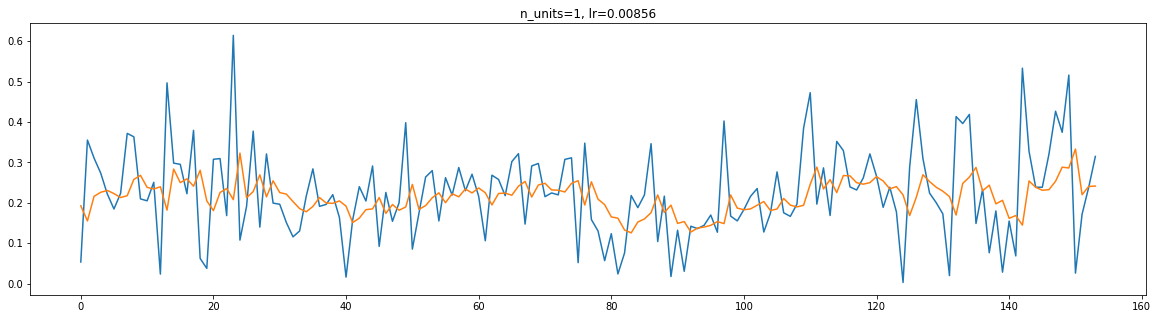

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.squeeze())
plt.plot(test_pred)
plt.title("n_units=1, lr=0.00856")

In [ ]:
# Split to training and test
coef = 0.1
split_size = int(len(steps_by_date.Steps) * (1 - coef))
#val_split_size = int(len(steps_by_date.Steps) * (1 - coef*2))
train_data, test_data = steps_by_date.Steps[:split_size], steps_by_date.Steps[split_size:]

"""# Normalize the data
scaler = MinMaxScaler() 
norm_train = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))
#norm_val = scaler.fit_transform(val_data.to_numpy().reshape(-1, 1))
norm_test = scaler.transform(test_data.to_numpy().reshape(-1, 1))"""

# Prepare
X_train, y_train = prepare_sequence(train_data.tolist()+test_data.tolist()[:1], 30, 1)
X_test, y_test = prepare_sequence(test_data, 30, 1)

normalised_x = []
normalised_y = []
for window in range(len(X_train)):
    normalised_window = [((float(p) / float(X_train[window, 0])) - 1) for p in X_train[window]]
    n_y = float(y_train[window]/X_train[window, 0] - 1)
    normalised_x.append(normalised_window)
    normalised_y.append(n_y)

y_train = np.array([normalised_y]).reshape(-1, 1)
X_train = np.array(normalised_x)

#y_test_unnorm = y_test
###### TEST
normalised_x = []
normalised_y = []
for window in range(len(X_test)):
    normalised_window = [((float(p) / float(X_test[window, 0])) - 1) for p in X_test[window]]
    n_y = float(y_test[window]/X_test[window, 0] - 1)
    normalised_x.append(normalised_window)
    normalised_y.append(n_y)

y_test = np.array([normalised_y]).reshape(-1, 1)
X_test = np.array(normalised_x)

# Reshape
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
#X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

input_shape = (X_train.shape[1], X_train.shape[2])
optimizer = Adam(0.01)

# Build the model
model = Sequential()
model.add(
    LSTM(
        200,
        input_shape=input_shape,
        activation='tanh'
        )
    )
model.add(Dense(1))

# Compile the model
model.compile(loss="mse", optimizer=optimizer, metrics=["mean_absolute_error"])

# Train the model
model.fit(
    X_train,
    y_train,
    validation_split=0.1,
    shuffle=False,
    batch_size=16,
    epochs=200,
    verbose=2,
    callbacks=[EarlyStopping("val_mean_absolute_error", 0, 10, restore_best_weights=True)]
)

display.Javascript("google.colab.output.setIframeHeight('300px');")

test_pred = model.predict(X_test)
print("MAE: ", round(mean_absolute_error(y_test.squeeze(), test_pred), 4))

shifted_pred = np.append(test_pred[1:], test_pred[-1])
print("Shifted MAE", round(mean_absolute_error(y_test.squeeze(), shifted_pred), 4))

Text(0.5, 1.0, 'n_units=200, lr=0.01')

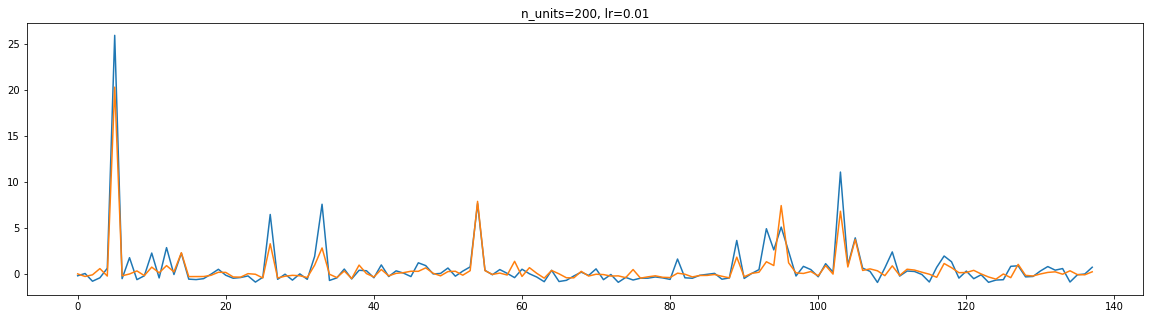

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(y_test.squeeze())
plt.plot(test_pred)
plt.title("n_units=200, lr=0.01")

In [ ]:
# Prepare
X_test_u, y_test_u = prepare_sequence(test_data, 30, 1)

In [ ]:
unnormalised_x = []
unnormalised_y = []
unnormalised_pred = []
normtest = X_test.reshape(X_test.shape[0], X_test.shape[1])
for window in range(len(normtest)):
    unnormalised_window = [X_test_u[window, 0]*(n + 1) for n in normtest[window]]
    u_y = X_test_u[window, 0]*(y_test[window] + 1)
    u_pred = X_test_u[window, 0]*(test_pred[window] + 1)
    unnormalised_x.append(unnormalised_window)
    unnormalised_y.append(u_y)
    unnormalised_pred.append(u_pred)

Text(0.5, 1.0, 'n_units=200, lr=0.01')

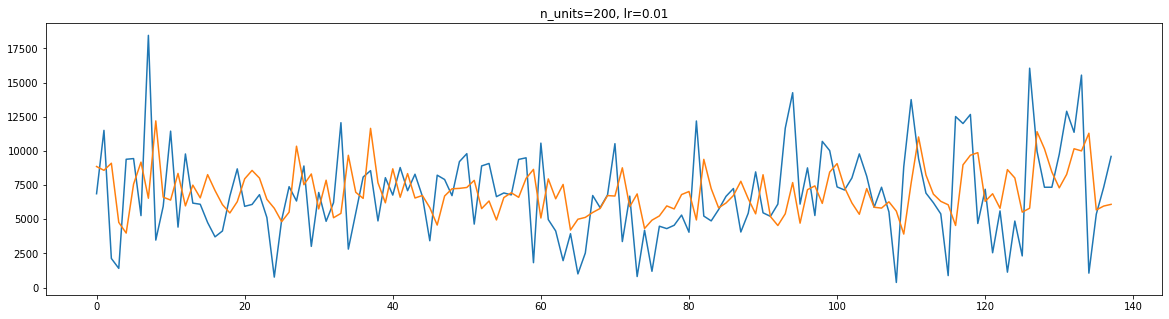

In [ ]:
plt.figure(figsize=(20, 5))
plt.plot(unnormalised_y)
plt.plot(unnormalised_pred)
plt.title("n_units=200, lr=0.01")

In [ ]:
mean_absolute_error(unnormalised_y, unnormalised_pred)

2861.4980221071105

In [ ]:
mean_absolute_error(scaler.transform(y_test_u), scaler.transform(unnormalised_pred))

0.09687186506337758

In [ ]:
mean_absolute_error(scaler.transform(y_test_u), scaler.transform(unnormalised_pred[1:]+unnormalised_pred[0:1]))
#len(unnormalised_pred[1:]+unnormalised_pred[0:1])

0.05958093521546037

In [ ]:
#pi = p0(ni + 1)
# n = normalized list [window] of price changes
# p = raw list [window] of adjusted daily return prices

In [ ]:
scaler = MinMaxScaler() 
norm_train = scaler.fit_transform(train_data.to_numpy().reshape(-1, 1))